## Data Analysis

In [688]:
#Install Packages

#!pip install openpyxl
#!pip install pandas
#!pip install matplotlib
#!pip install scipy
#!pip install simplejson
#!pip install seaborn

In [689]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
import json
import pickle
import seaborn as sns
import calendar

#### Assumptions

The objective is to analyse the profitability of investing in Cryptocurrency mining to make use of the excess energy produced in renewable energy.

In [690]:
# Load variables from the Global_Variables file

with open('Global_Variables.pkl', 'rb') as f:
    Global_Variables = pickle.load(f)

In [691]:
#Assumptions from CHE Report

#BTC Mining
Basis_MW = Global_Variables['Basis_MW'] #MW
Hardware_Eff = Global_Variables['Hardware_Eff'] #Percentage
W_from_Renewables = Global_Variables['W_from_Renewables'] #GW
P_from_Renewables = Global_Variables['P_from_Renewables'] #GW
P_from_Solar = Global_Variables['P_from_Solar']
Cooling = Global_Variables['Cooling'] #Percentage of excess energy produced by Solar Energy
Solar_Plant_W = Global_Variables['Solar_Plant_W'] #GW

#Solar Plant
#PV_Capacity = Global_Variables['PV_Capacity'] #MW Maximum capacity
Capital_Cost_PV = Global_Variables['Capital_Cost_PV'] #$/MW
PV_Plant_Cost = Global_Variables['PV_Plant_Cost'] #$
AC_capacity = Global_Variables['AC_capacity'] #MW Maximum capacity
PV_plant_capacity  = Global_Variables['PV_plant_capacity'] #MW
Off_peak_hours = Global_Variables['Off_peak_hours']
Energy_Demand = Global_Variables['Energy_Demand']
Electricity_Cost_USD = Global_Variables['Electricity_Cost_USD'] #USD per kWh for households

#Date of data extraction from Blockchain.com
current_year = Global_Variables['current_year']
last_date =  Global_Variables['last_date']
previous_year = Global_Variables['previous_year']
months = Global_Variables['months']
days_in_month = Global_Variables['days_in_month']
hours = Global_Variables['hours']

Data Sources:
- https://www.asicminervalue.com/
- https://www.blockchain.com/explorer/charts/

In [692]:
#Import Files

#Data used as basis
Solar_Data = Global_Variables['Solar_Data']
sheet_name_SolarData = 'Postmasburg'
skiprows = 31

#Data used as basis
Crypto_Data = Global_Variables['Crypto_Data']
#ASIC_df = pd.read_excel(Crypto_Data, sheet_name='Bitcoin Asic_data')
ASIC_df = Crypto_Data

#Bitcoin Data
hashrate_BTC = Global_Variables['hashrate_BTC']
revenue_BTC = Global_Variables['revenue_BTC']

#JSON file paths
file_paths = [hashrate_BTC,revenue_BTC]

In [693]:
start_date = pd.to_datetime(f'{previous_year}-01-01')
end_date = pd.to_datetime(last_date) - pd.Timedelta(days=366)

print(f"Start Date -> {start_date}")
print(f"End Date -> {end_date}")

Start Date -> 2024-01-01 00:00:00
End Date -> 2023-10-25 00:00:00


### PV Plant Data

##### Data Cleaning

In [694]:
data = []

for month in months:
    days = days_in_month[month - 1]
    for day in range(1, days + 1):
        for hour in hours:
            if hour in Off_peak_hours:
                energy_demand = 0
            else:
                energy_demand = Energy_Demand
            data.append({'Day': day, 'Month': month, 'Hour': hour, 'Energy Demand (MW)': energy_demand})

df_Energy_Demand = pd.DataFrame(data)


In [695]:
df_Energy_Demand.head()

,Day,Month,Hour,Energy Demand (MW)
0,1,1,0,0
1,1,1,1,0
2,1,1,2,0
3,1,1,3,0
4,1,1,4,0


In [696]:
#Create new columns with full dates

df_Energy_Demand['Day-Month-Year'] = pd.to_datetime(df_Energy_Demand['Day'].astype(str) + '-' + df_Energy_Demand['Month'].astype(str) + '-' + str(previous_year), 
                            format='%d-%m-%Y', errors='coerce')

# Replace year with 2024 for dates within the range
df_Energy_Demand['Day-Month-Year'] = df_Energy_Demand['Day-Month-Year'].apply(lambda x: x.replace(year=int(current_year)) if start_date <= x <= end_date else x)

df_Energy_Demand['Day-Month'] = df_Energy_Demand['Day-Month-Year'].dt.strftime('%d-%m')

df_Energy_Demand['Date'] = pd.to_datetime(df_Energy_Demand['Day-Month-Year'], format='%d-%B-%Y')
df_Energy_Demand = df_Energy_Demand[['Date','Day-Month','Hour','Energy Demand (MW)']]

df_Energy_Demand.head(10)

,Date,Day-Month,Hour,Energy Demand (MW)
0,2024-01-01,01-01,0,0
1,2024-01-01,01-01,1,0
2,2024-01-01,01-01,2,0
3,2024-01-01,01-01,3,0
4,2024-01-01,01-01,4,0
5,2024-01-01,01-01,5,0
6,2024-01-01,01-01,6,150
7,2024-01-01,01-01,7,150
8,2024-01-01,01-01,8,150
9,2024-01-01,01-01,9,150


In [697]:
#Read Files with validation check

df_PV = pd.read_excel(Solar_Data, sheet_name=sheet_name_SolarData, skiprows=skiprows)
df_PV.head()


,Month,Day,Hour,Beam Irradiance (W/m2),Diffuse Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Albedo,Plane of Array Irradiance (W/m2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,20.1,2.9,0.2,0.0,20.1,0.0,0.0
1,1,1,1,0,0,18.7,3.0,0.2,0.0,18.7,0.0,0.0
2,1,1,2,0,0,19.2,1.3,0.2,0.0,19.2,0.0,0.0
3,1,1,3,0,0,18.5,1.1,0.2,0.0,18.5,0.0,0.0
4,1,1,4,0,0,18.3,1.0,0.2,0.0,18.3,0.0,0.0


In [698]:
#Clean Data

df_PV['Month'] = df_PV['Month'].fillna(method='ffill')

C:\Users\HeldaMandlate\AppData\Local\Temp\ipykernel_33796\49855558.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_PV['Month'] = df_PV['Month'].fillna(method='ffill')


In [699]:
#List of all rows entries in column Month

df_PV['Month'].unique().tolist()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [700]:
df_PV.columns

Index(['Month', 'Day', 'Hour', 'Beam Irradiance (W/m2)',
       'Diffuse Irradiance (W/m2)', 'Ambient Temperature (C)',
       'Wind Speed (m/s)', 'Albedo', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'DC Array Output (W)', 'AC System Output (W)'],
      dtype='object')

In [701]:
#Create new columns with full dates

df_PV['Day-Month-Year'] = pd.to_datetime(df_PV['Day'].astype(str) + '-' + df_PV['Month'].astype(str) + '-' + str(previous_year), 
                            format='%d-%m-%Y', errors='coerce')

df_PV['Day-Month'] = df_PV['Day-Month-Year'].dt.strftime('%d-%m')

df_PV['Date'] = pd.to_datetime(df_PV['Day-Month-Year'], format='%d-%B-%Y')
df_PV = df_PV[['Date','Day-Month','Hour','AC System Output (W)']]

In [702]:
df_PV.head(10)

,Date,Day-Month,Hour,AC System Output (W)
0,2024-01-01,01-01,0,0.000000e+00
1,2024-01-01,01-01,1,0.000000e+00
2,2024-01-01,01-01,2,0.000000e+00
3,2024-01-01,01-01,3,0.000000e+00
4,2024-01-01,01-01,4,0.000000e+00
5,2024-01-01,01-01,5,0.000000e+00
6,2024-01-01,01-01,6,2.426402e+06
7,2024-01-01,01-01,7,2.014256e+07
8,2024-01-01,01-01,8,4.182478e+07
9,2024-01-01,01-01,9,5.814726e+07


In [703]:
#Surplus Energy in W

df_PV['AC System Output (MW)'] = df_PV['AC System Output (W)']/1000000
df_PV['Energy Generation (MW)'] = (df_PV['AC System Output (MW)']/AC_capacity)*PV_plant_capacity

df_PV['Energy for Mining (MW)'] = ((df_PV['Energy Generation (MW)'] - df_Energy_Demand['Energy Demand (MW)']) ).where(
    ((df_PV['Energy Generation (MW)'] - df_Energy_Demand['Energy Demand (MW)']) ) > 0, 0)



df_PV.head(10)

,Date,Day-Month,Hour,AC System Output (W),AC System Output (MW),Energy Generation (MW),Energy for Mining (MW)
0,2024-01-01,01-01,0,0.000000e+00,0.000000,0.000000,0.000000
1,2024-01-01,01-01,1,0.000000e+00,0.000000,0.000000,0.000000
2,2024-01-01,01-01,2,0.000000e+00,0.000000,0.000000,0.000000
3,2024-01-01,01-01,3,0.000000e+00,0.000000,0.000000,0.000000
4,2024-01-01,01-01,4,0.000000e+00,0.000000,0.000000,0.000000
5,2024-01-01,01-01,5,0.000000e+00,0.000000,0.000000,0.000000
6,2024-01-01,01-01,6,2.426402e+06,2.426402,12.132011,0.000000
7,2024-01-01,01-01,7,2.014256e+07,20.142561,100.712807,0.000000
8,2024-01-01,01-01,8,4.182478e+07,41.824776,209.123878,59.123878
9,2024-01-01,01-01,9,5.814726e+07,58.147261,290.736306,140.736306


In [704]:
df_PV['Energy for Mining (MW)'].sum()

np.float64(418575.66029698)

In [705]:
(df_PV['Energy for Mining (MW)'].sum())*1000*Electricity_Cost_USD/1000000 #ELECTRICITY REVENUE


np.float64(23.032814443928167)

In [706]:
df_PV['Energy Generation (MW)'].sum()

np.float64(926182.210258815)

In [707]:
df_PV['Energy for Mining (MW)'].sum()*100/df_PV['Energy Generation (MW)'].sum()

np.float64(45.1936622902757)

In [708]:
max_output = df_PV['Energy Generation (MW)'].max()
print(max_output)

416.66666666500004


In [709]:
#Plant Efficiency
eff = max_output/PV_plant_capacity
print(eff)

0.83333333333


In [710]:

df_PV['Energy for Mining (MW)'] = df_PV['Energy for Mining (MW)']*(1-Cooling)

# Replace year with 2024 for dates within the range
df_PV['Date'] = df_PV['Date'].apply(lambda x: x.replace(year=int(current_year)) if start_date <= x <= end_date else x)

relevant_columns = ['Date', 'Day-Month', 'Hour', 'Energy for Mining (MW)']
df_PV = df_PV[relevant_columns]

In [711]:
df_PV.head(10)

,Date,Day-Month,Hour,Energy for Mining (MW)
0,2024-01-01,01-01,0,0.000000
1,2024-01-01,01-01,1,0.000000
2,2024-01-01,01-01,2,0.000000
3,2024-01-01,01-01,3,0.000000
4,2024-01-01,01-01,4,0.000000
5,2024-01-01,01-01,5,0.000000
6,2024-01-01,01-01,6,0.000000
7,2024-01-01,01-01,7,0.000000
8,2024-01-01,01-01,8,47.299103
9,2024-01-01,01-01,9,112.589045


In [712]:
print(df_PV['Energy for Mining (MW)'].max())

213.33333333200005


In [713]:
df_PV = pd.merge(df_PV, df_Energy_Demand, how='inner', on=['Day-Month', 'Hour'])

In [714]:
df_PV.head(10)

,Date_x,Day-Month,Hour,Energy for Mining (MW),Date_y,Energy Demand (MW)
0,2024-01-01,01-01,0,0.000000,2024-01-01,0
1,2024-01-01,01-01,1,0.000000,2024-01-01,0
2,2024-01-01,01-01,2,0.000000,2024-01-01,0
3,2024-01-01,01-01,3,0.000000,2024-01-01,0
4,2024-01-01,01-01,4,0.000000,2024-01-01,0
5,2024-01-01,01-01,5,0.000000,2024-01-01,0
6,2024-01-01,01-01,6,0.000000,2024-01-01,150
7,2024-01-01,01-01,7,0.000000,2024-01-01,150
8,2024-01-01,01-01,8,47.299103,2024-01-01,150
9,2024-01-01,01-01,9,112.589045,2024-01-01,150


In [715]:
df_PV['Energy Demand (MW)'].sum()

np.int64(876000)

In [716]:
(df_PV['Energy Demand (MW)'].sum())*1000*Electricity_Cost_USD/1000000 #ELECTRICITY REVENUE



np.float64(48.20334139487624)

In [717]:
df_PV['Energy for Mining (MW)'].sum()

np.float64(334860.52823758405)

In [718]:
df_PV['Date'] = df_PV['Date_x']
relevant_columns = ['Date','Hour','Energy for Mining (MW)']
df_PV = df_PV[relevant_columns]
df_PV.head()

,Date,Hour,Energy for Mining (MW)
0,2024-01-01,0,0.0
1,2024-01-01,1,0.0
2,2024-01-01,2,0.0
3,2024-01-01,3,0.0
4,2024-01-01,4,0.0


In [719]:
#Annual surplus energy in MW
df_PV['Energy for Mining (MW)'].sum()

np.float64(334860.52823758405)

In [720]:
electricity_Sale = (0.0550266454279409*334860.52823758405*1000)/1000000
electricity_Sale

18.426251555142528

In [721]:
#Size of dataframe
df_PV.shape

(8760, 3)

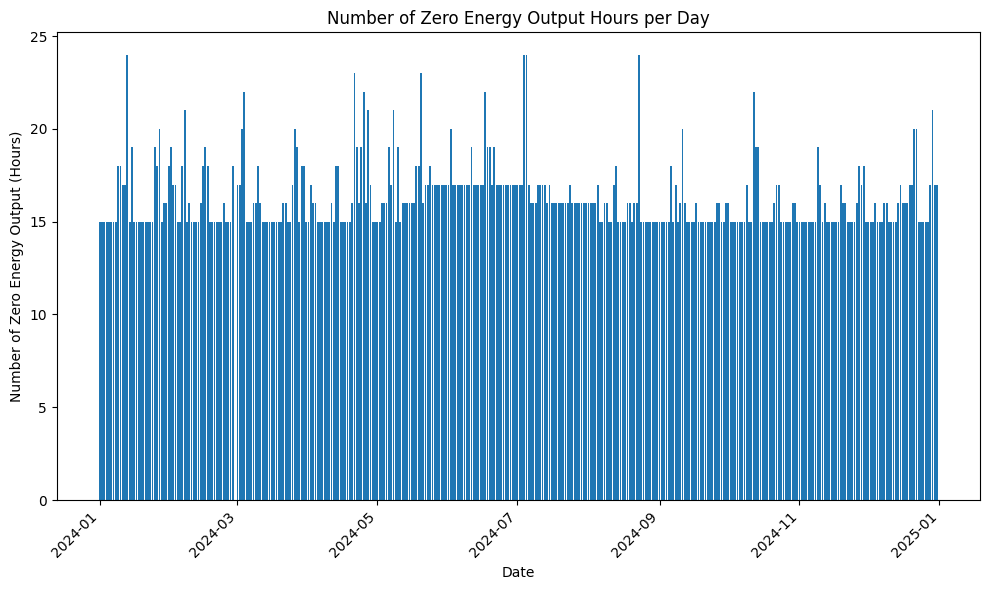

In [722]:
#Hours in a day with no Energy Production for Bitcoin
df_zero_energy_output = df_PV[df_PV['Energy for Mining (MW)'] == 0]

#Count the number of hours per day with zero energy output
zero_hours_per_day = df_zero_energy_output.groupby('Date')['Hour'].count().reset_index()
zero_hours_per_day.columns = ['Date', 'Zero_Hours']

#Identify which hours have zero energy output for each day
zero_hours_by_day = df_zero_energy_output.groupby('Date')['Hour'].apply(list).reset_index()

#Display results: Plot bar chart for the number of zero energy output hours per day
plt.figure(figsize=(10,6))
plt.bar(zero_hours_per_day['Date'], zero_hours_per_day['Zero_Hours'])
plt.xlabel('Date')
plt.ylabel('Number of Zero Energy Output (Hours)')
plt.title('Number of Zero Energy Output Hours per Day')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

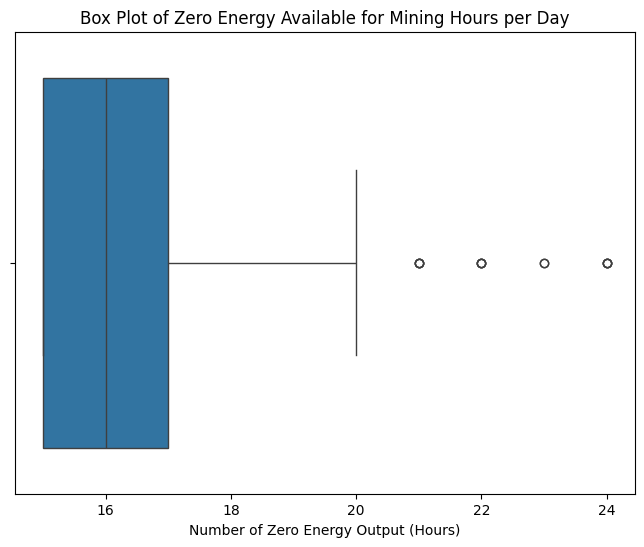

In [723]:
#Boxplot for the number of zero energy consumption hours per day
plt.figure(figsize=(8, 6))
sns.boxplot(x=zero_hours_per_day['Zero_Hours'])

plt.xlabel('Number of Zero Energy Output (Hours)')
plt.title('Box Plot of Zero Energy Available for Mining Hours per Day')
plt.show()


C:\Users\HeldaMandlate\AppData\Local\Temp\ipykernel_33796\2853649250.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(monthly_data, patch_artist=True, labels=[calendar.month_name[i] for i in range(1, 13)])


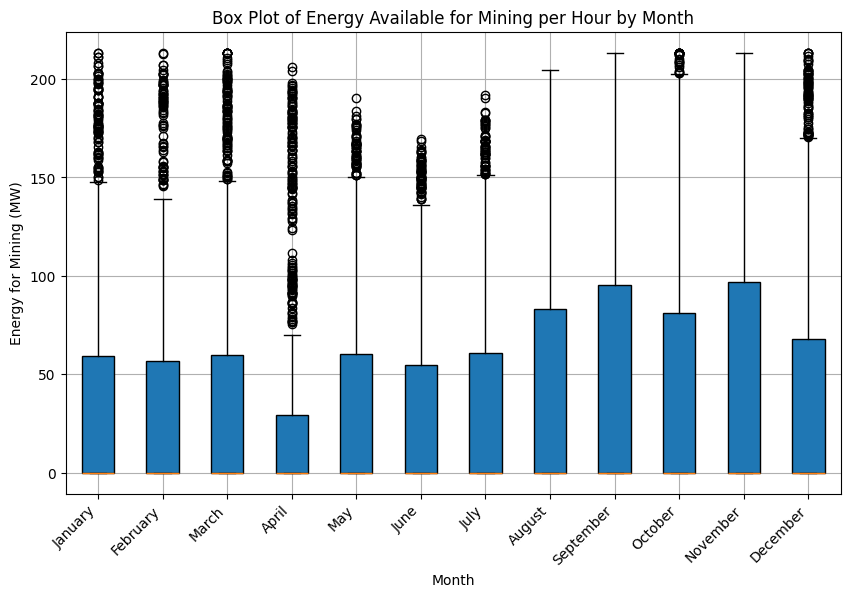

In [724]:
#Box plot per month of Energy Available for Mining, ie: Surplus Energy
df_PV['Month'] = df_PV['Date'].dt.month

monthly_data = [df_PV[df_PV['Month'] == month]['Energy for Mining (MW)'] for month in range(1, 13)]

plt.figure(figsize=(10, 6))
plt.boxplot(monthly_data, patch_artist=True, labels=[calendar.month_name[i] for i in range(1, 13)])

plt.title('Box Plot of Energy Available for Mining per Hour by Month')
plt.xlabel('Month')
plt.ylabel('Energy for Mining (MW)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.show()

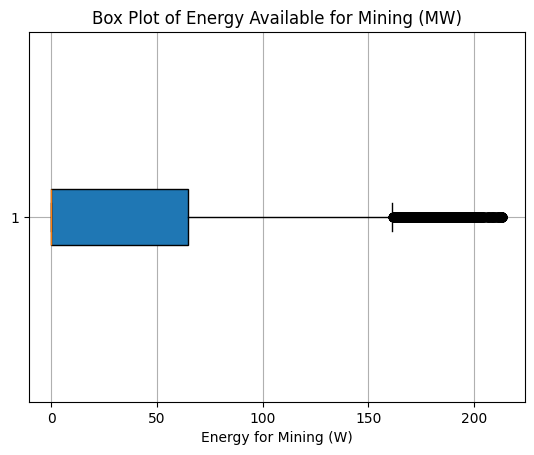

In [725]:
#Boxplot to view data distribution on Surplus per hour in one year

plt.boxplot([df_PV['Energy for Mining (MW)']], vert=False, patch_artist=True)
plt.title('Box Plot of Energy Available for Mining (MW)')
plt.xlabel('Energy for Mining (W)')
plt.grid(True)
plt.show()

In [726]:
ASIC_df = ASIC_df.loc[ASIC_df['Rig Type'] == 'ASIC']
ASIC_df.head()

,Model,Release,Hashrate (Th/s),Power (W),Algorithm,Income ($/day),Electricity Cost ($/day),With Electricity,Without Electricity,Efficiency (j/Gh),Price ($),Noise db,Cooling,Seller,Days to Breakeven,Rig Type
0,MicroBT WhatsMiner M63S,01-Nov-23,390.0,7215.0,SHA-256,20.29,-20.78,-0.49,20.29,0.019,12449.0,50.0,hydrocooling,AsicMarketPlace,613.553475,ASIC
1,Bitmain Antminer S21 Hyd (335Th),01-Feb-24,335.0,5360.0,SHA-256,17.43,-15.44,1.99,17.43,0.016,5889.0,50.0,hydrocooling,AsicMarketPlace,337.865749,ASIC
2,MicroBT WhatsMiner M63,01-Nov-23,334.0,6646.0,SHA-256,17.38,-19.14,-1.76,17.38,0.020,6879.0,50.0,hydrocooling,AsicMarketPlace,395.799770,ASIC
3,MicroBT WhatsMiner M66S,01-Nov-23,298.0,5513.0,SHA-256,15.51,-15.88,-0.37,15.51,0.019,9649.0,50.0,hydrocooling,AsicMarketPlace,622.114765,ASIC
4,Bitmain Antminer S21 Pro (234Th),01-Jul-24,234.0,3531.0,SHA-256,12.18,-10.17,2.01,12.18,0.015,5029.0,75.0,2 fans,AsicMarketPlace,412.889984,ASIC


In [727]:
ASIC_df.columns

Index(['Model', 'Release', 'Hashrate (Th/s)', 'Power (W)', 'Algorithm',
       'Income ($/day)', 'Electricity Cost ($/day)', 'With Electricity',
       'Without Electricity', 'Efficiency (j/Gh)', 'Price ($)', 'Noise db',
       'Cooling', 'Seller', 'Days to Breakeven', 'Rig Type'],
      dtype='object')

In [728]:
#Create dictionary with ASIC data

column_pairs = ['Release', 'Hashrate (Th/s)', 'Power (W)', 'Algorithm',
       'Income ($/day)', 'Electricity Cost ($/day)', 'With Electricity',
       'Without Electricity', 'Efficiency (j/Gh)', 'Price ($)', 'Noise db',
       'Cooling', 'Seller', 'Days to Breakeven']
dicts = {}

for col in column_pairs:
    dict_name = f"dict_{col}"
    dicts[dict_name] = ASIC_df.set_index('Model')[col].to_dict()

for name, dictionary in dicts.items():
    print(f"{name} -> {dictionary}")

dict_Release -> {'MicroBT WhatsMiner M63S': '01-Nov-23', 'Bitmain Antminer S21 Hyd (335Th)': '01-Feb-24', 'MicroBT WhatsMiner M63': '01-Nov-23', 'MicroBT WhatsMiner M66S': '01-Nov-23', 'Bitmain Antminer S21 Pro (234Th)': '01-Jul-24', 'Bitmain Antminer S21 (200Th)': '01-Feb-24', 'Bitmain Antminer T21 (190Th)': '01-Feb-24', 'MicroBT WhatsMiner M60S': '01-Feb-24', 'Canaan Avalon A1566': '01-Oct-24', 'MicroBT WhatsMiner M60': '01-Feb-24', 'Bitmain Antminer S19j Pro (104Th)': '01-Jul-21', 'Bitmain Antminer S19 Pro (110Th)': '01-May-20'}
dict_Hashrate (Th/s) -> {'MicroBT WhatsMiner M63S': 390.0, 'Bitmain Antminer S21 Hyd (335Th)': 335.0, 'MicroBT WhatsMiner M63': 334.0, 'MicroBT WhatsMiner M66S': 298.0, 'Bitmain Antminer S21 Pro (234Th)': 234.0, 'Bitmain Antminer S21 (200Th)': 200.0, 'Bitmain Antminer T21 (190Th)': 190.0, 'MicroBT WhatsMiner M60S': 186.0, 'Canaan Avalon A1566': 185.0, 'MicroBT WhatsMiner M60': 172.0, 'Bitmain Antminer S19j Pro (104Th)': 104.0, 'Bitmain Antminer S19 Pro (110T

In [729]:
# Number of Rigs per Model
for model, power_ in dicts['dict_Power (W)'].items():
    df_PV[model] = (np.ceil(df_PV['Energy for Mining (MW)'] * 1_000_000 / power_)).astype(int)

df_PV.head(10)


,Date,Hour,Energy for Mining (MW),Month,MicroBT WhatsMiner M63S,Bitmain Antminer S21 Hyd (335Th),MicroBT WhatsMiner M63,MicroBT WhatsMiner M66S,Bitmain Antminer S21 Pro (234Th),Bitmain Antminer S21 (200Th),Bitmain Antminer T21 (190Th),MicroBT WhatsMiner M60S,Canaan Avalon A1566,MicroBT WhatsMiner M60,Bitmain Antminer S19j Pro (104Th),Bitmain Antminer S19 Pro (110Th)
0,2024-01-01,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2024-01-01,1,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2024-01-01,2,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2024-01-01,3,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2024-01-01,4,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
5,2024-01-01,5,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
6,2024-01-01,6,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
7,2024-01-01,7,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0
8,2024-01-01,8,47.299103,1,6556,8825,7117,8580,13396,13324,13103,13746,13831,13823,15417,14554
9,2024-01-01,9,112.589045,1,15605,21006,16941,20423,31886,31716,31189,32720,32921,32902,36698,34643


In [730]:
df_PV_copy = df_PV.copy()

In [731]:
df_PV.columns

Index(['Date', 'Hour', 'Energy for Mining (MW)', 'Month',
       'MicroBT WhatsMiner M63S', 'Bitmain Antminer S21 Hyd (335Th)',
       'MicroBT WhatsMiner M63', 'MicroBT WhatsMiner M66S',
       'Bitmain Antminer S21 Pro (234Th)', 'Bitmain Antminer S21 (200Th)',
       'Bitmain Antminer T21 (190Th)', 'MicroBT WhatsMiner M60S',
       'Canaan Avalon A1566', 'MicroBT WhatsMiner M60',
       'Bitmain Antminer S19j Pro (104Th)',
       'Bitmain Antminer S19 Pro (110Th)'],
      dtype='object')

In [732]:
columns_to_exclude = ['Date', 'Hour', 'Energy for Mining (MW)', 'Month',
       #'MicroBT WhatsMiner M63S',
       #'Bitmain Antminer S21 Hyd (335Th)', 'MicroBT WhatsMiner M63',
       #'MicroBT WhatsMiner M66S', 'Bitmain Antminer S21 Pro (234Th)',
       #'Bitmain Antminer S21 (200Th)', 'Bitmain Antminer T21 (190Th)',
       #'MicroBT WhatsMiner M60S', 'Canaan Avalon A1566',
       #'MicroBT WhatsMiner M60', 'Bitmain Antminer S19j Pro (104Th)',
       #'Bitmain Antminer S19 Pro (110Th)'
       ]

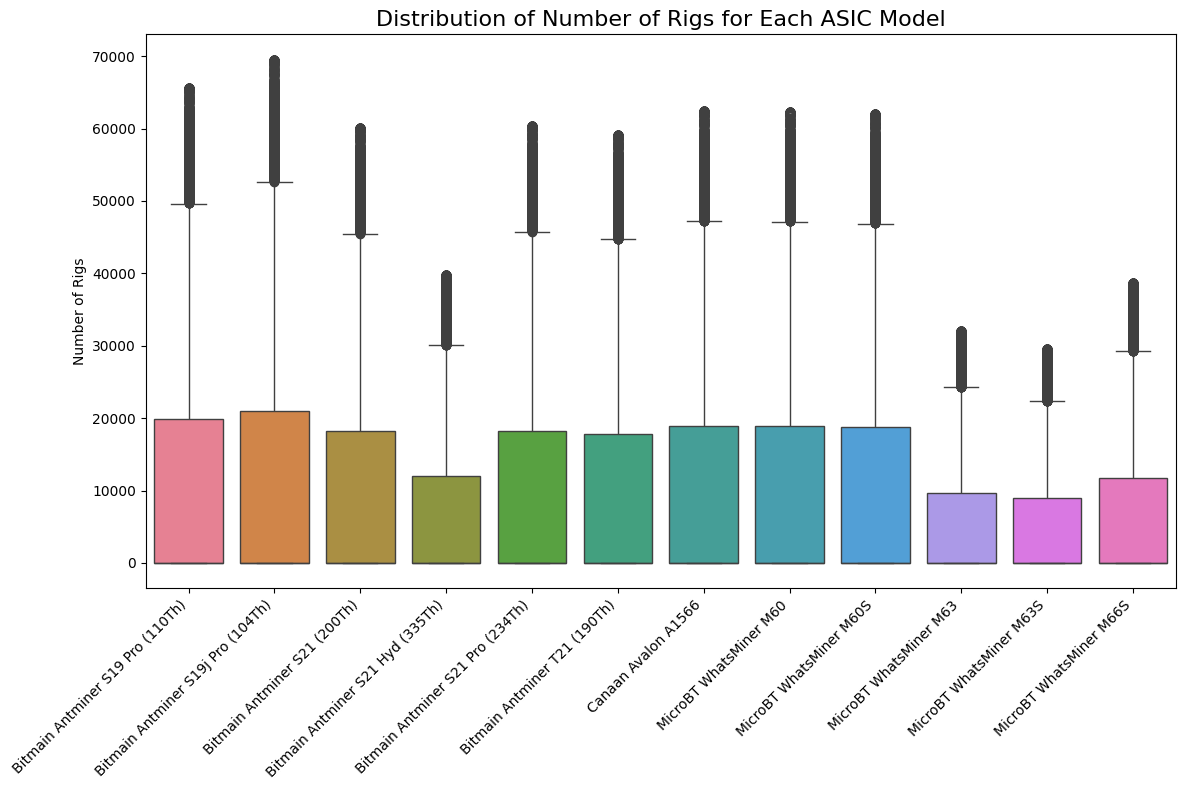

In [733]:
plt.figure(figsize=(12, 8))

columns_to_plot = df_PV.columns.difference(columns_to_exclude)

sns.boxplot(data=df_PV[columns_to_plot])

plt.title('Distribution of Number of Rigs for Each ASIC Model', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Number of Rigs')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [734]:
numeric_columns = df_PV.drop(columns=columns_to_exclude).select_dtypes(include=[np.number])

max_values = numeric_columns.max().to_dict()

print(max_values)

{'MicroBT WhatsMiner M63S': 29569, 'Bitmain Antminer S21 Hyd (335Th)': 39801, 'MicroBT WhatsMiner M63': 32100, 'MicroBT WhatsMiner M66S': 38697, 'Bitmain Antminer S21 Pro (234Th)': 60418, 'Bitmain Antminer S21 (200Th)': 60094, 'Bitmain Antminer T21 (190Th)': 59096, 'MicroBT WhatsMiner M60S': 61998, 'Canaan Avalon A1566': 62379, 'MicroBT WhatsMiner M60': 62342, 'Bitmain Antminer S19j Pro (104Th)': 69535, 'Bitmain Antminer S19 Pro (110Th)': 65642}


C:\Users\HeldaMandlate\AppData\Local\Temp\ipykernel_33796\3790858304.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=list(max_values.keys()), y=list(max_values.values()), palette="viridis")


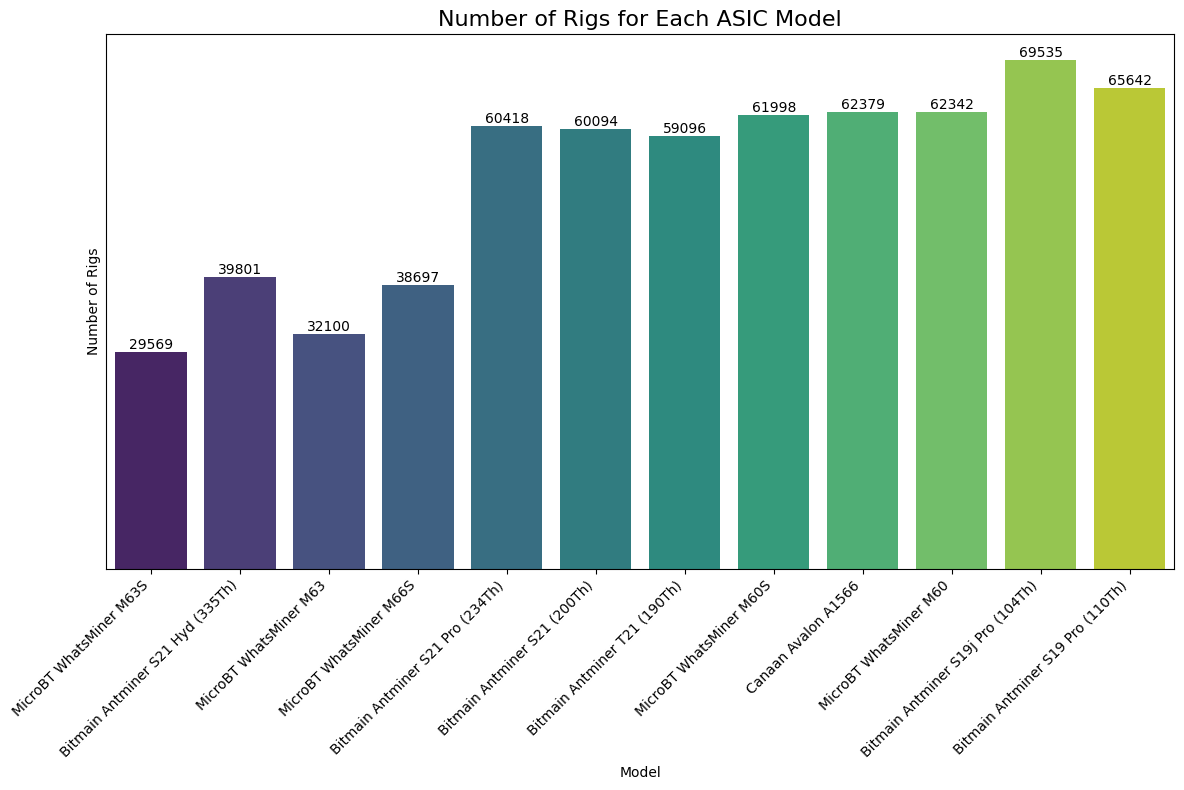

In [735]:
plt.figure(figsize=(12, 8))

bars = sns.barplot(x=list(max_values.keys()), y=list(max_values.values()), palette="viridis")

plt.title('Number of Rigs for Each ASIC Model', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Rigs')
plt.xlabel('Model')

plt.yticks([])

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f'{int(bar.get_height())}',
             ha='center', 
             va='bottom')

plt.tight_layout()
plt.show()

In [736]:
#Save all relevant variables

with open('DataAnalysisVariables.pkl', 'wb') as f:
    pickle.dump({'NumberofRigsPerModel': max_values,
                 'df_PV_copy': df_PV_copy,
                 
                 }, f)